In [1]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Replace with the GPU index you want to use

# Confirm the selected GPU
print(f"Using GPU {os.environ['CUDA_VISIBLE_DEVICES']} for the experiment.")

Using GPU 1 for the experiment.


In [26]:
#imports
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy
import seaborn as sns
import math
import json
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [3]:
print(tf.__version__)

2.13.0


In [4]:
#Prepare Training Data:
path_to_X = "./Normalised/X.npy"
path_to_Y = "./Normalised/Y.npy"
X = np.load(path_to_X)
Y = np.load(path_to_Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
print(len(X_train))
print(len(X_test))
# Reshape the input and output data for the encoder and decoder
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # (No of Data, 50) to (No of data, 50,1)
print("X_train_reshaped shape: ", X_train_reshaped.shape)
Y_train_reshaped = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
print("Y_train_resahped shape: ", Y_train_reshaped.shape)
# Define the input shape for the encoder
input_shape = X_train_reshaped.shape[1:]  # Shape: (sequence_length, 1) # 50,1
print("Input_shape: ", input_shape)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test_reshaped = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)
print("X_test_reshaped",X_test_reshaped.shape)
print("Y_test_reshaped",Y_test_reshaped.shape)

49730
12433
X_train_reshaped shape:  (49730, 50, 1)
Y_train_resahped shape:  (49730, 81, 1)
Input_shape:  (50, 1)
X_test_reshaped (12433, 50, 1)
Y_test_reshaped (12433, 81, 1)


In [5]:
# Define the model
def createModel(units, optimizer):        
    # Define the encoder
    encoder_inputs = Input(shape=input_shape)
    encoder_lstm = LSTM(units)(encoder_inputs)
    encoder_model = Model(encoder_inputs, encoder_lstm)
    
    # Define the input shape for the decoder (with 40 units to match encoder LSTM units)
    decoder_inputs = Input(shape=(units,))  # This will serve as the initial state of the decoder LSTM
    decoder_lstm = LSTM(units, return_sequences=True)(RepeatVector(Y_train_reshaped.shape[1])(decoder_inputs))
    decoder_outputs = Dense(1, activation='sigmoid')(decoder_lstm)
    
    # Define the decoder model
    decoder_model = Model(decoder_inputs, decoder_outputs)
    
    # Create the full autoencoder model
    autoencoder_outputs = decoder_model(encoder_lstm)
    autoencoder = Model(encoder_inputs, autoencoder_outputs)
    
    # Compile the model
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error', metrics = ['mae'])
    
    # Display the model summary
    autoencoder.summary()
    return autoencoder

In [6]:
#Train the model
#Train the model
# Enable logging of device placement
tf.debugging.set_log_device_placement(False)

# Verify the available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs:", gpus)
if gpus:
    # Use the first GPU for training
    with tf.device('/GPU:1'):
        autoencoder = createModel(64,'adam')
        save_path = "./Saved_Models_Data/P20_U64_OA/"
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
        mc = ModelCheckpoint(save_path+"best_enc_dec.h5", monitor = 'val_loss',mode='min', save_best_only=True, verbose=1)
        history = autoencoder.fit(X_train_reshaped, Y_train_reshaped, batch_size=32, epochs=200, validation_split=0.2, callbacks=[early_stopping, mc])
        with open(save_path+'history.json','w') as file:
            json.dump(history.history, file)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-07 20:54:08.904615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78946 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:25:00.0, compute capability: 8.0


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 model_1 (Functional)        (None, 81, 1)             33089     
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


2023-11-07 20:54:13.280580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-07 20:54:13.429503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-07 20:54:13.430204: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f53bd50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-07 20:54:13.430236: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-07 20:54:13.437129: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-07 20:54:13.557348: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process

1242/1244 [============================>.] - ETA: 0s - loss: 0.1119 - mae: 0.2304
Epoch 1: val_loss improved from inf to 0.09763, saving model to ./Saved_Models_Data/P20_U64_OA/best_enc_dec.h5
1244/1244 [==============================] - 19s 12ms/step - loss: 0.1118 - mae: 0.2303 - val_loss: 0.0976 - val_mae: 0.1986
Epoch 2/200
  16/1244 [..............................] - ETA: 13s - loss: 0.0887 - mae: 0.1873

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1243/1244 [============================>.] - ETA: 0s - loss: 0.0846 - mae: 0.1745
Epoch 2: val_loss improved from 0.09763 to 0.07930, saving model to ./Saved_Models_Data/P20_U64_OA/best_enc_dec.h5
1244/1244 [==============================] - 15s 12ms/step - loss: 0.0846 - mae: 0.1745 - val_loss: 0.0793 - val_mae: 0.1585
Epoch 3/200
1243/1244 [============================>.] - ETA: 0s - loss: 0.0762 - mae: 0.1535
Epoch 3: val_loss improved from 0.07930 to 0.06972, saving model to ./Saved_Models_Data/P20_U64_OA/best_enc_dec.h5
1244/1244 [==============================] - 15s 12ms/step - loss: 0.0762 - mae: 0.1535 - val_loss: 0.0697 - val_mae: 0.1445
Epoch 4/200
1244/1244 [==============================] - ETA: 0s - loss: 0.0685 - mae: 0.1382
Epoch 4: val_loss improved from 0.06972 to 0.06633, saving model to ./Saved_Models_Data/P20_U64_OA/best_enc_dec.h5
1244/1244 [==============================] - 15s 12ms/step - loss: 0.0685 - mae: 0.1382 - val_loss: 0.0663 - val_mae: 0.1369
Epoch 5/20

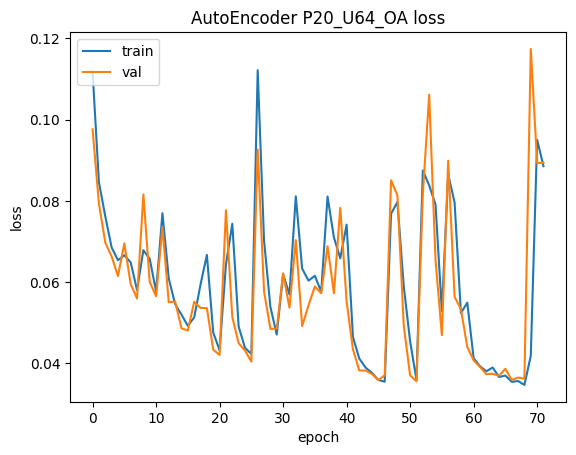

In [8]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('AutoEncoder P20_U64_OA loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
#Evaluate the saved best model:
from tensorflow.keras.models import load_model
saved_model = load_model("./Saved_Models_Data/P20_U64_OA/best_enc_dec.h5")
best_eval = saved_model.evaluate(X_test_reshaped, Y_test_reshaped)

print("Mean Squared Error: ", best_eval[0])
print("Mean Absolute Error: ", best_eval[1])

#RMSE:
mse_value = best_eval[0]
rmse_value = np.sqrt(mse_value)
print("Root Mean Squared Error (RMSE): ", rmse_value)

389/389 [==============================] - 3s 5ms/step - loss: 0.0356 - mae: 0.0683
Mean Squared Error:  0.03560927137732506
Mean Absolute Error:  0.06832541525363922
Root Mean Squared Error (RMSE):  0.1887041901424689


In [33]:
save_path = "./Saved_Models_Data/P20_U64_OA/"

In [11]:
#Save the predictions
predictions = saved_model.predict(X_test_reshaped)
original_shape_predictions = predictions.reshape(X_test.shape[0], Y_test.shape[1])
np.save(save_path+"predictions.npy",original_shape_predictions)

#Save the ground truth:
np.save(save_path+"ground-truth.npy", Y_test)

389/389 [==============================] - 2s 4ms/step


In [19]:
save_path = "./Saved_Models_Data/P20_U64_OA/"
#Load the ground truth and predictions:
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path +"ground-truth.npy")

print(y_pred.shape)
print(y_true.shape)
#Print some samples:
for sample in range(5):
    print(f"SAMPLE: {sample}")
    for i in range (81):
        print(f"Index {i} Ground truth: {y_true[sample][i]} Predicted: {y_pred[sample][i]}")

(12433, 81)
(12433, 81)
SAMPLE: 0
Index 0 Ground truth: 0 Predicted: 0.023289602249860764
Index 1 Ground truth: 0 Predicted: 0.27695274353027344
Index 2 Ground truth: 1 Predicted: 0.788524866104126
Index 3 Ground truth: 0 Predicted: 6.844564632046968e-05
Index 4 Ground truth: 0 Predicted: 4.236877430230379e-05
Index 5 Ground truth: 0 Predicted: 0.0002697400632314384
Index 6 Ground truth: 0 Predicted: 6.0223588661756366e-05
Index 7 Ground truth: 0 Predicted: 1.9803052055067383e-05
Index 8 Ground truth: 0 Predicted: 9.616007446311414e-05
Index 9 Ground truth: 0 Predicted: 0.0022868968080729246
Index 10 Ground truth: 0 Predicted: 0.0002663033956196159
Index 11 Ground truth: 0 Predicted: 0.0007495625177398324
Index 12 Ground truth: 0 Predicted: 0.0014693462289869785
Index 13 Ground truth: 1 Predicted: 0.9848396182060242
Index 14 Ground truth: 0 Predicted: 0.004289994016289711
Index 15 Ground truth: 0 Predicted: 0.00022517619072459638
Index 16 Ground truth: 0 Predicted: 0.000892386888153851

In [20]:
#Can convert to Benesh version for predictions using a threshold here
print("Converting the predictions to benesh versions:")
benesh_arr = np.zeros_like(y_pred)

for sample in range(len(y_pred)):
  #print(f"SAMPLE: {sample}")
  for i in range (81):
    # can add more logic here to change the thresholds for specific indices.
    if y_pred[sample][i] >= 0.5:
      benesh_arr[sample][i] = 1
    elif y_pred[sample][i] < 0.5:
      benesh_arr[sample][i]= 0

print(benesh_arr[:2])
np.save(save_path+"y_pred_benesh.npy", benesh_arr)

Converting the predictions to benesh versions:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]]


In [21]:
#save the error array
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path+"ground-truth.npy")

err_arr = np.zeros((12433,81))

for r in range(len(y_pred)):
    for c in range(81):
        err_arr[r][c] = abs(y_true[r][c]-y_pred[r][c])
        
np.save(save_path+"err_arr.npy",err_arr)

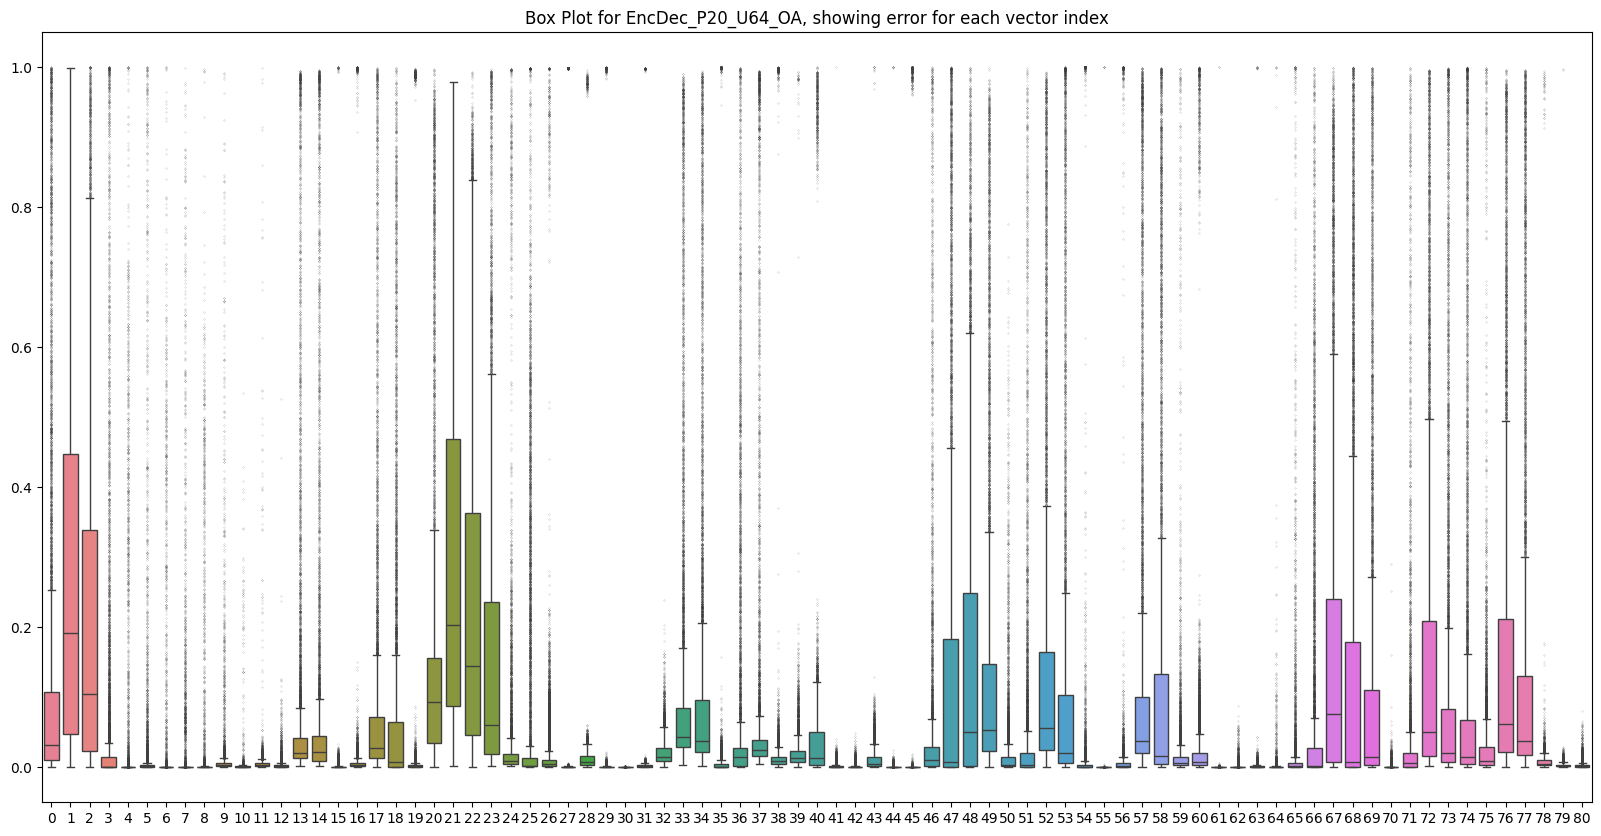

In [24]:
err_arr = np.load(save_path+"err_arr.npy")
#fig, ax = plt.subplots(figsize=(18, 9))
plt.figure(figsize = (20,10))
sns.boxplot(err_arr, fliersize = 0.1 ,gap=0.05).set(title='Box Plot for EncDec_P20_U64_OA, showing error for each vector index')
plt.show()

In [23]:
def mean_abs_perc_err(gt_arr, pred_arr, num_samples, vec_size):
    err_arr = np.zeros((num_samples,vec_size))
    print("Calculating MAPE")
    for r in range(len(pred_arr)):
        for c in range(vec_size):
          err_arr[r][c] = abs(gt_arr[r][c]-pred_arr[r][c]) # Calculation of the percentage error
    per_sample_mape_arr = np.sum(err_arr,axis=1)/vec_size
    print(per_sample_mape_arr.shape)
    print("MAPE for 10 samples...",per_sample_mape_arr[:10])
    overall_MAPE = sum(per_sample_mape_arr)/num_samples
    print("OVERALL MAPE: ", overall_MAPE)

n_samples = 12433
v_size = 81
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path+"ground-truth.npy")
mean_abs_perc_err(y_true,y_pred,n_samples,v_size)

Calculating MAPE
(12433,)
MAPE for 10 samples... [0.04354079 0.03820885 0.04381862 0.05453051 0.09784592 0.04871019
 0.10380632 0.1252149  0.08291669 0.05834462]
OVERALL MAPE:  0.06832544553846516


In [28]:
from sklearn.metrics import r2_score

In [29]:
y_pred = np.load(save_path+"predictions.npy")
y_true = np.load(save_path+"ground-truth.npy")

In [30]:
#Calculate R2 Score:
result_r2 = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the R-squared value for each row
    r2 = r2_score(y_true[i, :], y_pred[i, :])
    result_r2[i] = r2

print("R-squared value for each row (sample):", result_r2)
# Calculate the overall R-squared value
overall_r2 = np.mean(result_r2)

# Print the overall R-squared value
print("Overall R-squared value:", overall_r2)

R-squared value for each row (sample): [0.89865479 0.92738423 0.92030508 ... 0.81899382 0.72402898 0.77371481]
Overall R-squared value: 0.7178351696668127


In [31]:
#Spearman Correlation:
result = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Spearman correlation for each row
    row_result = scipy.stats.spearmanr(y_true[i, :], y_pred[i, :])

    # Checking for zero standard deviation
    if np.isnan(row_result.correlation) or np.isnan(row_result.pvalue):
        # Handle the case where the result contains NaN
        result[i] = 0  # Set the correlation coefficient to 0
    else:
        result[i] = row_result.correlation

print("Spearman correlation coefficients for each row (sample):", result)
overall_spearman_corr = np.mean(result)

# Print the overall Spearman correlation coefficient
print("Overall Spearman correlation coefficient:", overall_spearman_corr)

Spearman correlation coefficients for each row (sample): [0.61535237 0.61535237 0.61535237 ... 0.58711156 0.47117561 0.51428   ]
Overall Spearman correlation coefficient: 0.5685290307352268


In [32]:
#Pearson Correlation:
result_pearson = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Pearson correlation for each row
    corr_matrix = np.corrcoef(y_true[i, :], y_pred[i, :])
    result_pearson[i] = corr_matrix[0, 1]

# Calculate the overall Pearson correlation coefficient
overall_pearson_corr = np.mean(result_pearson)

print("Pearson correlation coefficients for each row:", result_pearson)
print(len(result_pearson))
# Print the overall Pearson correlation coefficient
print("Overall Pearson correlation coefficient:", overall_pearson_corr)

Pearson correlation coefficients for each row: [0.9508331  0.96629328 0.96429597 ... 0.90627672 0.85251314 0.88010273]
12433
Overall Pearson correlation coefficient: 0.8453674062271442


In [34]:
from sklearn.metrics import matthews_corrcoef
y_pred = np.load(save_path + "y_pred_benesh.npy")
y_true = np.load(save_path + "ground-truth.npy")

result_mcc = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Matthews Correlation Coefficient for each row
    mcc = matthews_corrcoef(y_true[i, :], y_pred[i, :])
    result_mcc[i] = mcc

# Calculate the overall Matthews Correlation Coefficient
overall_mcc = np.mean(result_mcc)

# Print the overall Matthews Correlation Coefficient
print("Overall Matthews Correlation Coefficient:", overall_mcc)

Overall Matthews Correlation Coefficient: 0.8104365011758778
